In [60]:
# Import necessary libraries.
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random as rnd
import datetime as dt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.vector_ar import var_model
from statsmodels.tsa.regime_switching import markov_autoregression

In [56]:
#Create simulation data to play with models.
pi_days = np.linspace(-(np.pi/2), np.pi*3+(np.pi/2), 730)
pi_day = pi_days[1]-pi_days[0]

AmeanT = 12; Aexp = 18
air_curve = np.sin(pi_days); sd = (air_curve+2)*1.5
noise = np.random.normal(0,sd,730)
air = air_curve * Aexp + AmeanT + noise

WmeanT = 8; Wexp = 10
water_curve = np.sin(pi_days - (pi_day*15)); sd = (water_curve+1.1)
noise = np.random.normal(0,sd,730)
water = water_curve * Wexp + WmeanT + noise

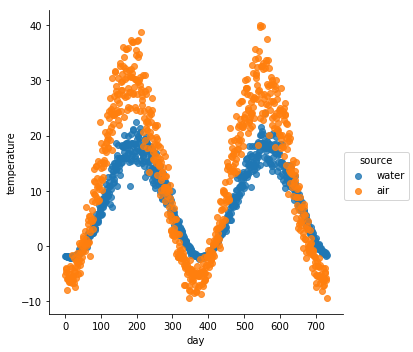

In [57]:
# Plot data simulation of air and water temperature.
dat = pd.DataFrame({'water':water,'air':air,'day':np.arange(1,731)})
dat = dat.melt(id_vars=['day'], value_vars=['water','air'], var_name='source', value_name='temperature')

sns.lmplot(x='day', y='temperature', data=dat, hue='source', fit_reg=False)

In [58]:
rnd.seed(a=9)

dep=244 #Deployed Logger
ret=dep+365 #Retrieved Logger

err_day = rnd.randint(dep+1,ret-1,) #Day the error occurs
dur = rnd.randint(0,(ret-err_day)) #Period of time the error continues

#Filter down to the period of 'monitoring'.
sim = dat[(dat.day>=dep) & (dat.day<=ret)]

#Filter out water values when air temperature was being gathered.
rm_wtr = sim[-(((sim.day==dep) & (sim.source=='water') | 
                (sim.day==ret) & (sim.source=='water')) | 
               ((sim.day>=err_day) & (sim.day<=err_day+dur) & (sim.source=="water")))]

#Filter out air temperature when water temperature was being gathered.
rm_air = rm_wtr[-(((rm_wtr.day>dep) & (rm_wtr.day<err_day) & (rm_wtr.source=='air')) | 
                ((rm_wtr.day>(err_day+dur)) & (rm_wtr.day<ret) & (rm_wtr.source=="air")))]

sim_out = rm_air
sim_out = sim_out.reset_index(drop=True)

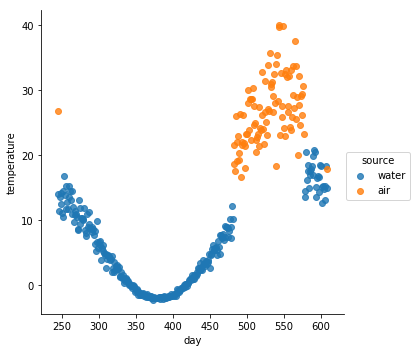

In [59]:
# Plot the data and the fit.
sns.lmplot(x='day',y='temperature',data=sim_out,
          hue='source', fit_reg=False)

In [74]:
day = pd.datetime(2000,1,1) + pd.Timedelta(sim_out.day[0],'D')
date = pd.date_range(day, periods = sim_out.shape[0], freq = 'D')

model = ARIMA(sim_out.temperature, order=(1,0,0), dates=date)
model_fit = model.fit()
#print(model_fit.summary())

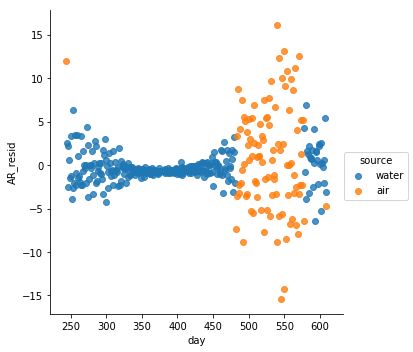

In [72]:
test = pd.DataFrame({'AR_resid':model_fit.resid})
test = pd.concat([sim_out,test],axis=1)

sns.lmplot(x='day', y='AR_resid', data=test,
         hue='source', fit_reg=False)
#plt.scatter(test.day, test.AR_fit, color = 'black', alpha = 0.5)

In [449]:
#sim_out['dates'] = date
#test = sim_out.set_index('dates')

#model = markov_autoregression.MarkovAutoregression(endog=test.temperature, k_regimes=2, order=1, trend='nc', switching_variance=True)
#model_fit = model.fit()
#model_fit.summary()
date


DatetimeIndex(['2000-09-02', '2000-09-03', '2000-09-04', '2000-09-05',
               '2000-09-06', '2000-09-07', '2000-09-08', '2000-09-09',
               '2000-09-10', '2000-09-11',
               ...
               '2001-08-24', '2001-08-25', '2001-08-26', '2001-08-27',
               '2001-08-28', '2001-08-29', '2001-08-30', '2001-08-31',
               '2001-09-01', '2001-09-02'],
              dtype='datetime64[ns]', length=366, freq='D')